<h1> Stock Moving Average Strategy </h1>
<p> Question: Could you use the moving average cross over strategy to make a profit off of certain stocks? </p>

In [300]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

Populating the interactive namespace from numpy and matplotlib


In [301]:
#API to get specific stock metrics (dividends, ratios, etc)
TeslaEPS = pd.DataFrame.from_csv("http://finance.yahoo.com/d/quotes.csv?s=TSLA&f=e")
TeslaEPS

""
-8.4510


In [302]:
#I didn't write this
pylab.rcParams['figure.figsize'] = (15, 9) 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [288]:
#pulling historical stock data for Apple
apple = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=AAPL&a=10&b=11&c=2011&d=10&e=11&f=2016&g=d&ignore=.csv")

In [303]:
#dropping the index to reset it so that the dates go in order from oldest to newest
apple = apple.reset_index()
apple = apple.sort_values('Date')
apple = apple.set_index('Date')
apple.head()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2011-11-11,386.609997,388.700005,380.259998,384.619991,163446500,50.304195,NaN,NaN,NaN,NaN
2011-11-14,383.519993,385.249992,378.200005,379.260002,108226300,49.603165,NaN,NaN,NaN,NaN
2011-11-15,380.800011,389.499996,379.449993,388.829994,107702700,50.854818,NaN,NaN,NaN,NaN
2011-11-16,389.250004,391.140007,384.320011,384.770008,87302600,50.323815,NaN,NaN,NaN,NaN
2011-11-17,383.980003,384.579990,375.499996,377.410000,119975100,49.361205,NaN,NaN,NaN,NaN


In [304]:
#creating new data columns to use with our trading strategy
#20d = 20 day moving average (average closing price for the previous 20 days)

apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2016-10-06,113.699997,114.339996,113.129997,113.889999,28779300,113.889999,112.22,109.31,102.10,2.91
2016-10-07,114.309998,114.559998,113.510002,114.059998,24358400,114.059998,112.77,109.50,102.14,3.27
2016-10-10,115.019997,116.750000,114.720001,116.050003,36236000,116.050003,113.30,109.74,102.17,3.56
2016-10-11,117.699997,118.690002,116.199997,116.300003,64041000,116.300003,113.72,109.94,102.22,3.78
2016-10-12,117.349998,117.980003,116.750000,117.339996,37479600,117.339996,113.99,110.20,102.27,3.79


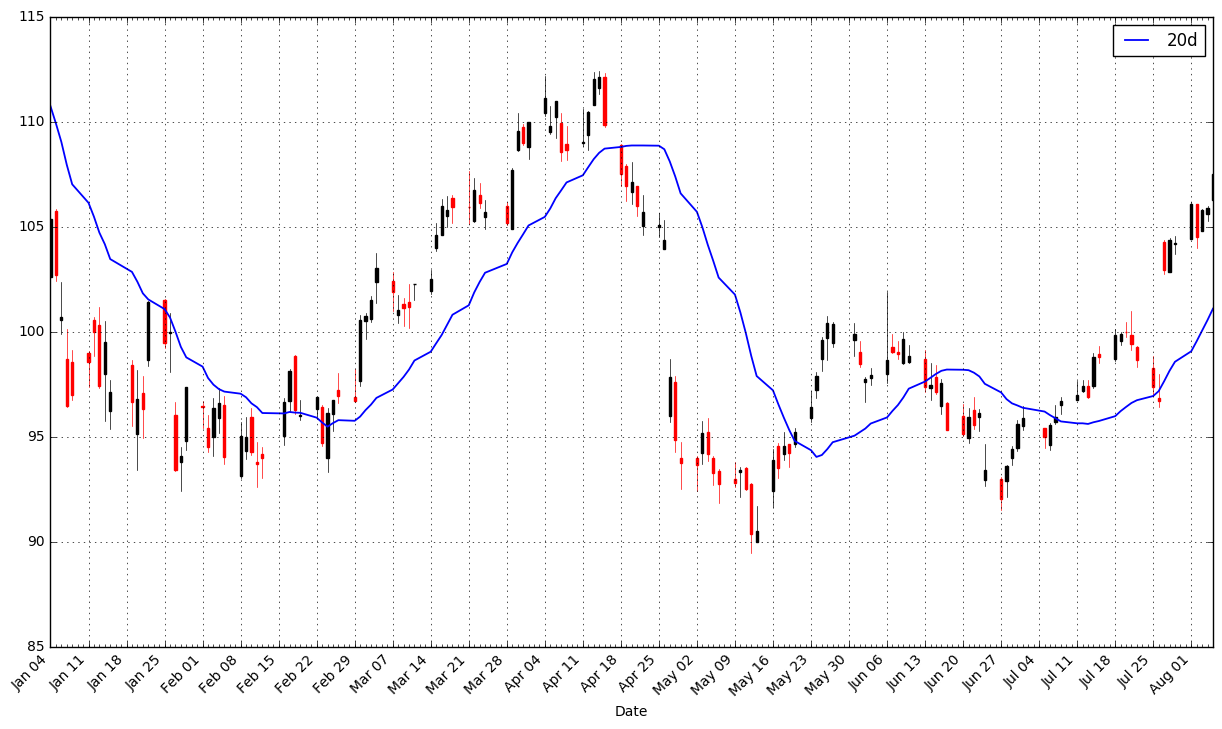

In [305]:
#plot showing the delay between changes in the actual stock price and the
#time it takes the 20d value to reflect these changes

pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

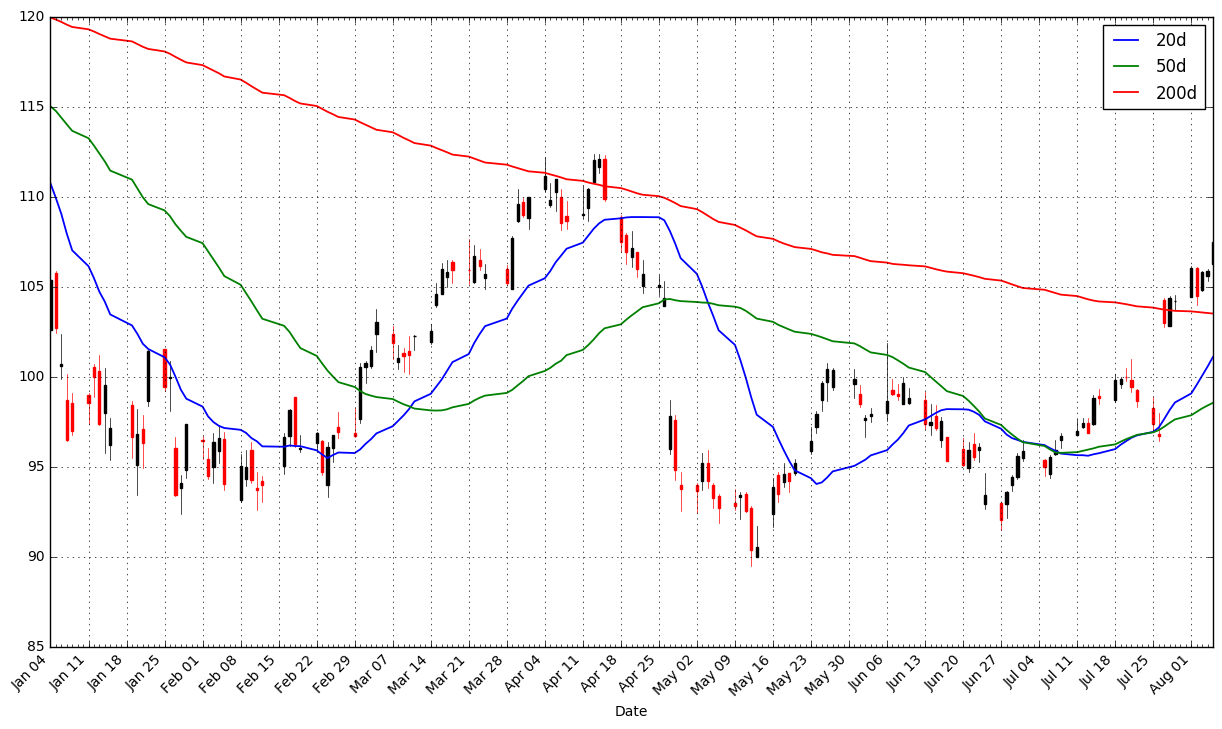

In [306]:
#plot showing even greater lag with the 50d and 200d moving averages
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

<p> Next we will begin to implement our trading strategy. We'll be using a moving average crossover strategy, which signals whether to buy/sell stock based on when two moving averages, fast=20d & slow=50d, cross eachother. <br><br>
The two main points of the strategy are:<ul>
<li>Trade the asset when the fast moving average crosses over the slow moving average</li>
<li>Exit the trade when the fast moving average crosses over the slow moving average again</li></ul>
<br>
Two types of trades:<ul>
<li>Long trade - purchasing an asset with the assumption that it's price will increase and you can sell it for a profit (long positions are referred to as bullish)</li>
<li>Short trade - borrowing the asset from a lender with the assumption that it will decrease in value, sell the borrowed asset now and then later buy it back at a cheaper price and return it to the lender, you keep the difference as profit (short positions are referred to as bearish)</li></ul>
<br>
A long trade will be prompted when the fast moving average crosses from below to above the slow moving average, and the trade will be exited when the fast moving average crosses below the slow moving average later. A short trade will be prompted when the fast moving average crosses below the slow moving average, and the trade will be exited when the fast moving average later crosses above the slow moving average.<br>
We'll apply this trading strategy to historical stock data to see how well it performs.
</p>

In [307]:
#seeing when the 20d average is below the 50d average
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2016-10-06,113.699997,114.339996,113.129997,113.889999,28779300,113.889999,112.22,109.31,102.10,2.91
2016-10-07,114.309998,114.559998,113.510002,114.059998,24358400,114.059998,112.77,109.50,102.14,3.27
2016-10-10,115.019997,116.750000,114.720001,116.050003,36236000,116.050003,113.30,109.74,102.17,3.56
2016-10-11,117.699997,118.690002,116.199997,116.300003,64041000,116.300003,113.72,109.94,102.22,3.78
2016-10-12,117.349998,117.980003,116.750000,117.339996,37479600,117.339996,113.99,110.20,102.27,3.79


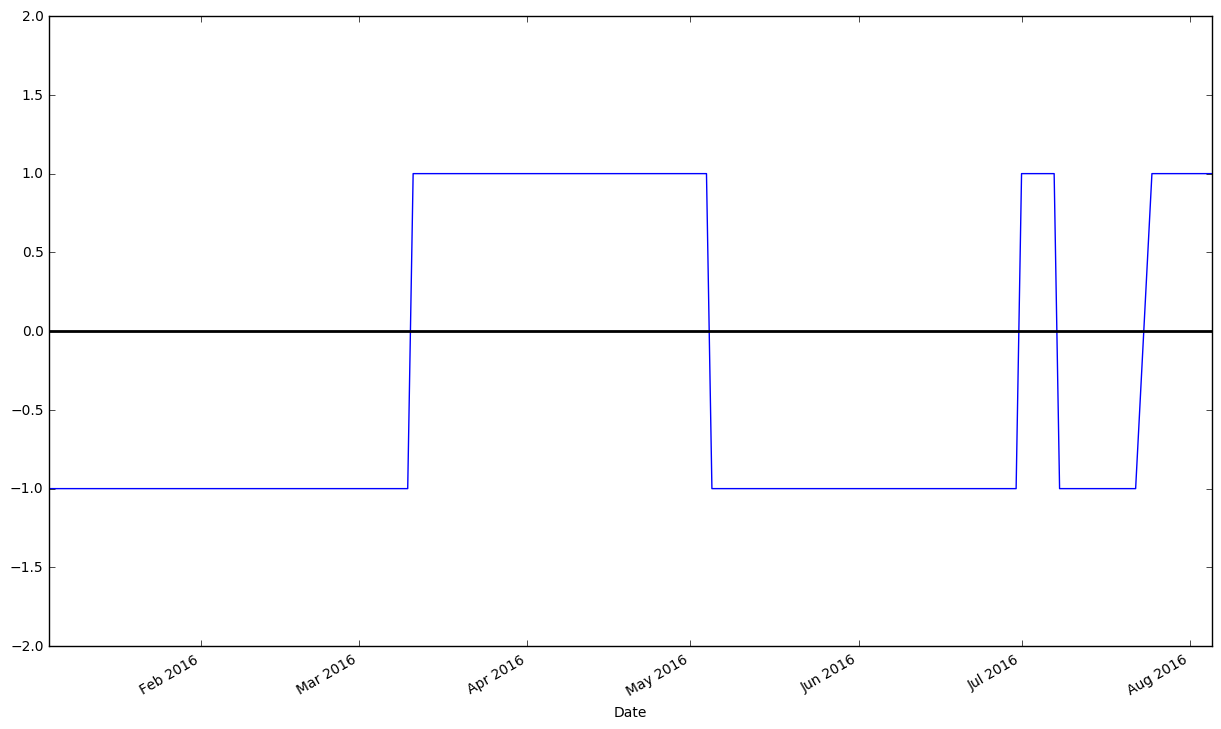

In [308]:
#assigning 0s, 1s, and -1s to where there is a crossover from the averages
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


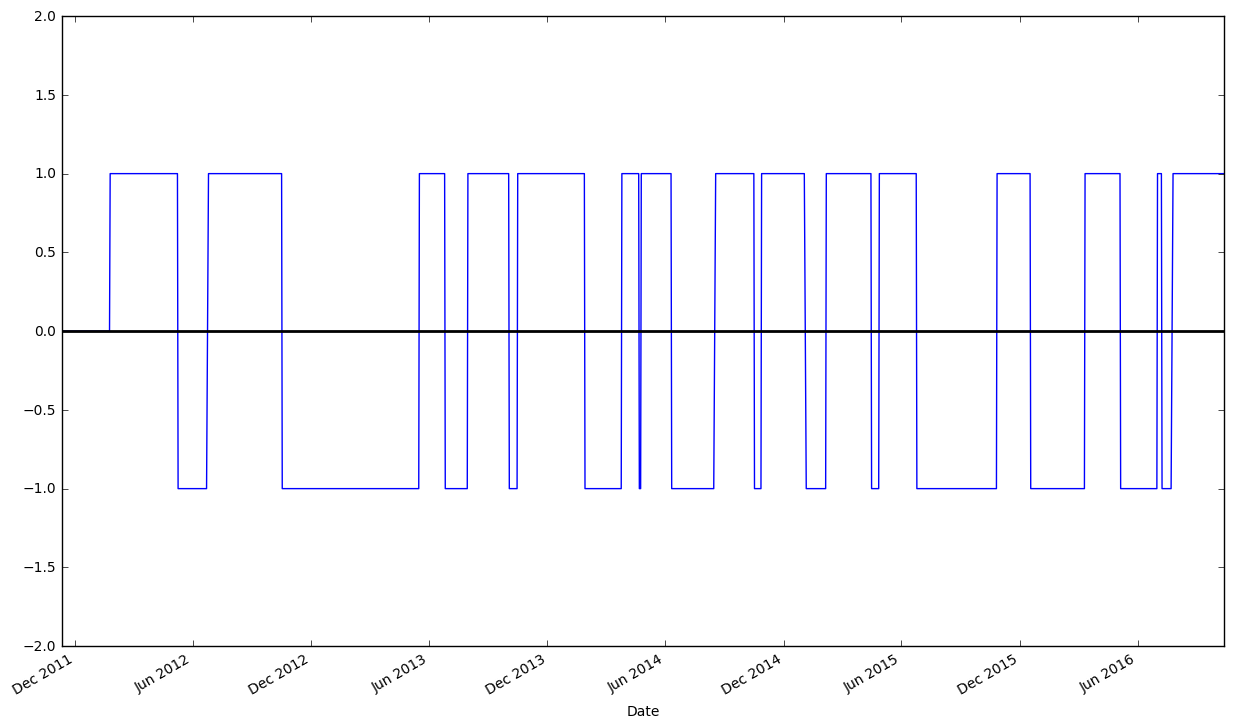

In [309]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [310]:
apple["Regime"].value_counts()

 1    659
-1    529
 0     49
Name: Regime, dtype: int64

<p>The market for Apple stock was bullish for 659 days, bearish for 529, and neutral for 49 days.</p>

In [313]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
# Trading signals happen when the regime changes
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2016-10-06,113.699997,114.339996,113.129997,113.889999,28779300,113.889999,112.22,109.31,102.10,2.91,1.0,0.0
2016-10-07,114.309998,114.559998,113.510002,114.059998,24358400,114.059998,112.77,109.50,102.14,3.27,1.0,0.0
2016-10-10,115.019997,116.750000,114.720001,116.050003,36236000,116.050003,113.30,109.74,102.17,3.56,1.0,0.0
2016-10-11,117.699997,118.690002,116.199997,116.300003,64041000,116.300003,113.72,109.94,102.22,3.78,1.0,0.0
2016-10-12,117.349998,117.980003,116.750000,117.339996,37479600,117.339996,113.99,110.20,102.27,3.79,1.0,-1.0


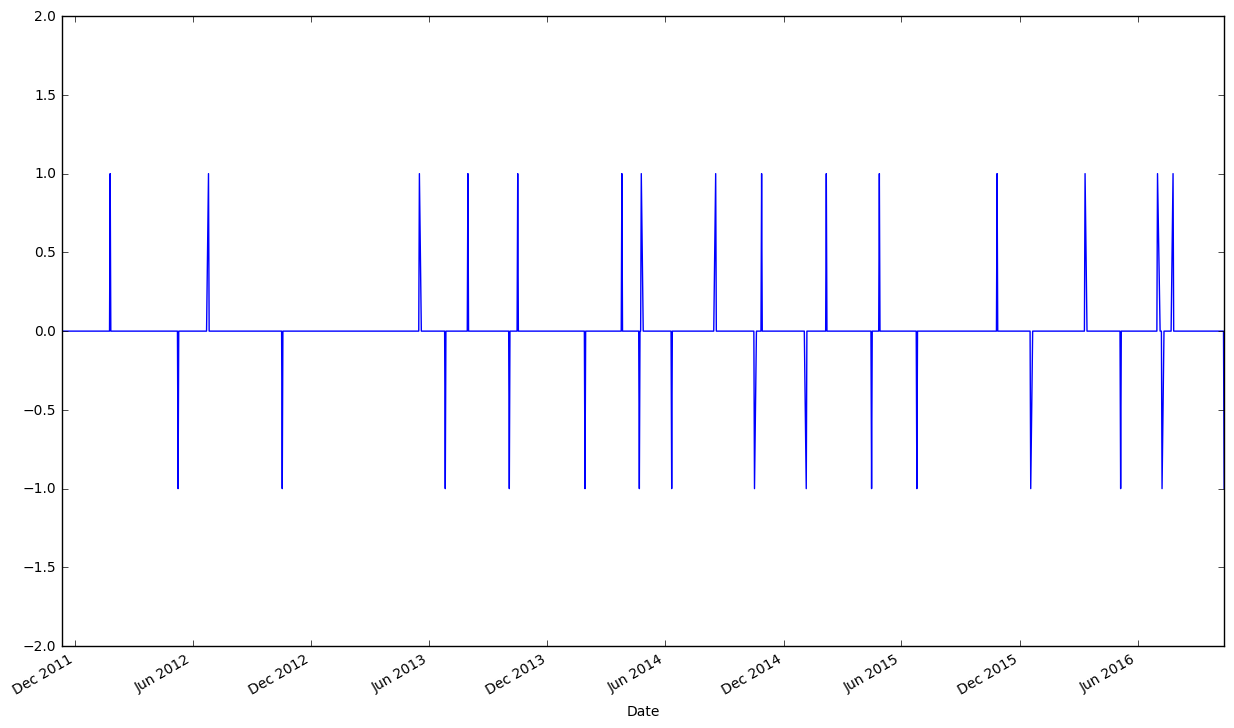

In [314]:
apple["Signal"].plot(ylim = (-2, 2))

In [315]:
apple["Signal"].value_counts()

 0.0    1206
-1.0      15
 1.0      15
Name: Signal, dtype: int64

In [316]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2012-01-25    446.659996
2012-06-25    570.770020
2013-05-17    433.260010
2013-07-31    452.529984
2013-10-16    501.110001
2014-03-26    539.779991
2014-04-25    571.939980
2014-08-18     99.160004
2014-10-28    106.739998
2015-02-05    119.940002
2015-04-28    130.559998
2015-10-27    114.550003
2016-03-11    102.260002
2016-07-01     95.889999
2016-07-25     97.339996
Name: Close, dtype: float64

In [317]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2012-05-09    569.180023
2012-10-17    644.610001
2013-06-26    398.069992
2013-10-03    483.409996
2014-01-28    506.499977
2014-04-22    531.700020
2014-06-11     93.860001
2014-10-17     97.669998
2015-01-05    106.250000
2015-04-16    126.169998
2015-06-25    127.500000
2015-12-18    106.029999
2016-05-05     93.239998
2016-07-08     96.680000
2016-10-12    117.339996
Name: Close, dtype: float64

In [318]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2012-01-25,446.659996,1.0,Buy
2012-05-09,569.180023,-1.0,Sell
2012-06-25,570.770020,1.0,Buy
2012-10-17,644.610001,-1.0,Sell
2013-05-17,433.260010,1.0,Buy
2013-06-26,398.069992,-1.0,Sell
2013-07-31,452.529984,1.0,Buy
2013-10-03,483.409996,-1.0,Sell
2013-10-16,501.110001,1.0,Buy


In [320]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2012-01-25,2012-05-09,446.659996,122.520027
2012-06-25,2012-10-17,570.770020,73.839981
2013-05-17,2013-06-26,433.260010,-35.190018
2013-07-31,2013-10-03,452.529984,30.880012
2013-10-16,2014-01-28,501.110001,5.389976
2014-03-26,2014-04-22,539.779991,-8.079971
2014-04-25,2014-06-11,571.939980,-478.079979
2014-08-18,2014-10-17,99.160004,-1.490006
2014-10-28,2015-01-05,106.739998,-0.489998


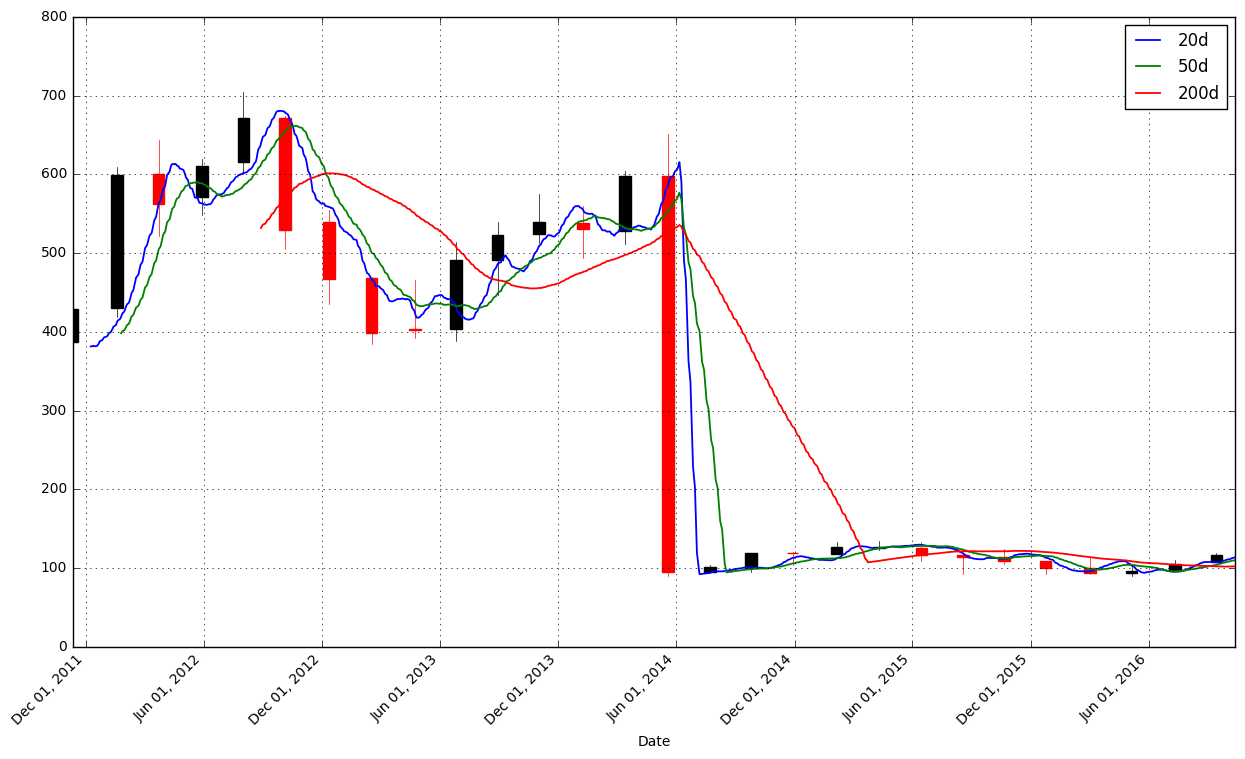

In [321]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])


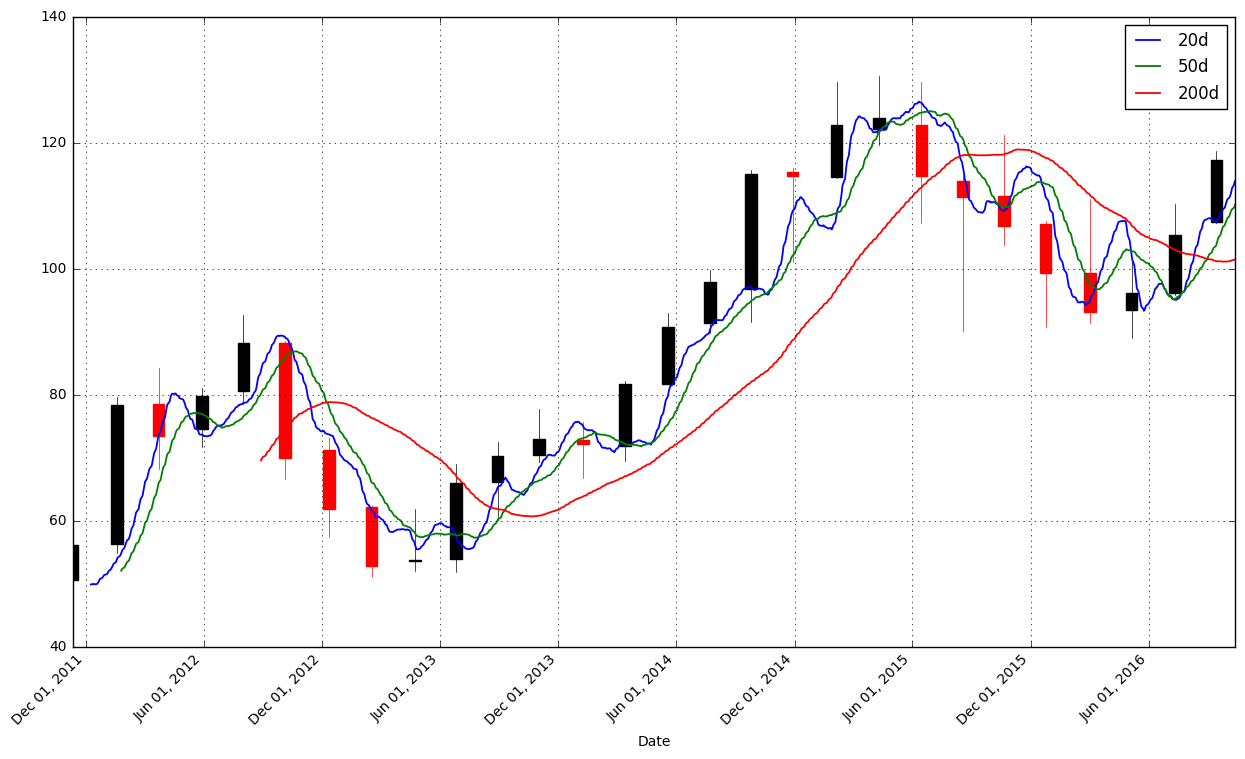

In [322]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [282]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2012-01-25,2012-05-09,58.418366,16.024313,57.957988
2012-06-25,2012-10-17,74.650634,10.019459,73.975759
2013-05-17,2013-06-26,57.882798,-4.701326,52.859502
2013-07-31,2013-10-04,60.457234,4.500835,60.043080
2013-10-16,2014-01-28,67.389473,1.122523,67.136651
2014-03-11,2014-03-17,72.948554,-1.272298,71.167335
2014-03-24,2014-04-22,73.370393,-1.019203,69.579335
2014-04-25,2014-10-17,77.826851,16.191371,76.740971
2014-10-28,2015-01-05,102.749105,-0.028185,101.411076


In [283]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2012-01-25,2012-05-09,1.027241e+06,16.024313,58.418366,1700.0,1.000000e+06,0.0,27241.3321,99311.2222
2012-06-25,2012-10-17,1.040267e+06,10.019459,74.650634,1300.0,1.027241e+06,0.0,13025.2967,97045.8242
2013-05-17,2013-06-26,1.032274e+06,-4.701326,57.882798,1700.0,1.040267e+06,0.0,-7992.2542,98400.7566
2013-07-31,2013-10-04,1.039926e+06,4.500835,60.457234,1700.0,1.032274e+06,0.0,7651.4195,102777.2978
2013-10-16,2014-01-28,1.041610e+06,1.122523,67.389473,1500.0,1.039926e+06,0.0,1683.7845,101084.2095
2014-03-11,2014-03-17,1.039828e+06,-1.272298,72.948554,1400.0,1.041610e+06,0.0,-1781.2172,102127.9756
2014-03-24,2014-04-22,1.038401e+06,-1.019203,73.370393,1400.0,1.039828e+06,0.0,-1426.8842,102718.5502
2014-04-25,2014-10-17,1.059450e+06,16.191371,77.826851,1300.0,1.038401e+06,0.0,21048.7823,101174.9063
2014-10-28,2015-01-05,1.059422e+06,-0.028185,102.749105,1000.0,1.059450e+06,0.0,-28.1850,102749.1050
2015-02-05,2015-04-16,1.064864e+06,6.046838,116.413846,900.0,1.059422e+06,0.0,5442.1542,104772.4614


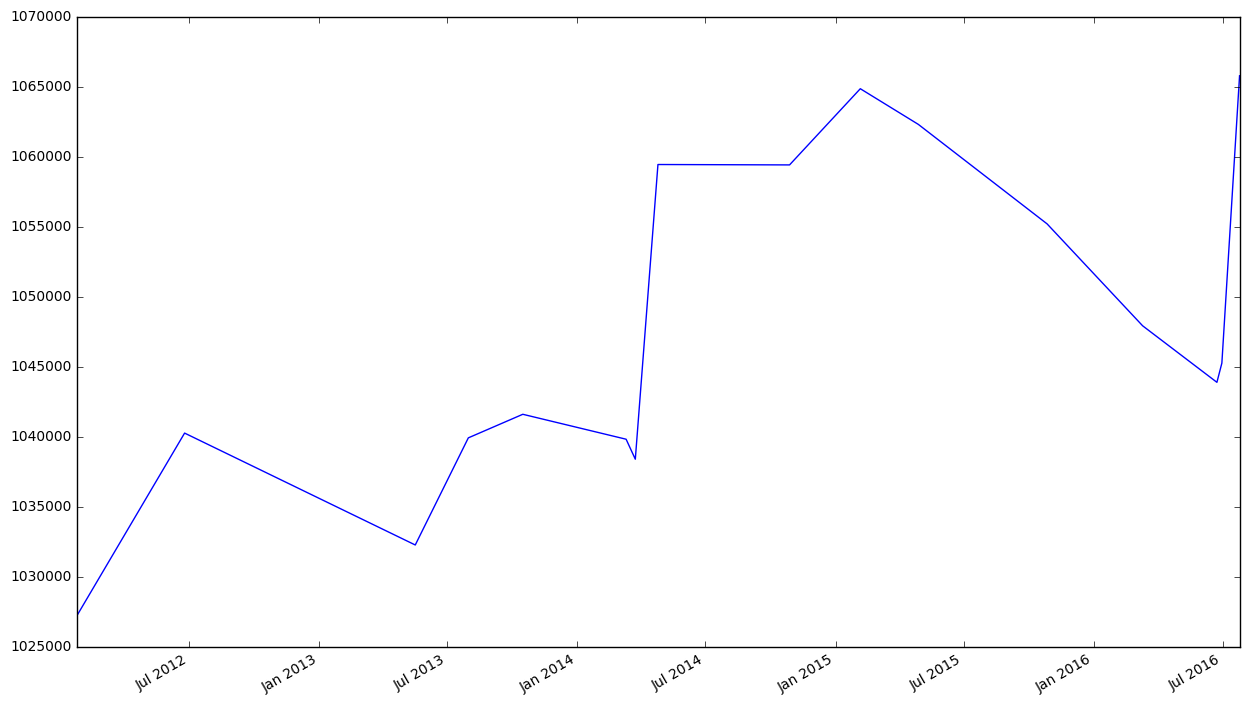

In [284]:
apple_backtest["End Port. Value"].plot()